# Tutorial

This quick tutorial shows how to perform diffusion-weighted MRI simulations using Disimpy. To follow along, [install](https://disimpy.readthedocs.io/en/latest/installation.html) the package and execute the code in each cell in the order that they are presented here. More information about the functions and their parameters can be found in the function docstrings.

You can also use Google Colaboratory to [run this notebook interactively in your browser](https://colab.research.google.com/github/kerkelae/disimpy/blob/master/docs/source/tutorial.ipynb) even if you don't have an Nvidia CUDA-capable GPU. To use a GPU on Google Colaboratory, select *Runtime > Change runtime type > Hardware Type: GPU* in the top menu.

In [1]:
# If Disimpy has not been installed, please uncomment the following line and
# execute the code in this cell

#!pip install git+https://github.com/kerkelae/disimpy.git

In [2]:
# Import the packages and modules used in this tutorial

import os
import numpy as np
import matplotlib.pyplot as plt

from disimpy import gradients, simulations, substrates, utils

## Simulation parameters

First, we need to define the number of random walkers and diffusivity. In this tutorial, we will use a small number of random walkers to keep the simuation runtime short and to be able to visualize the simulated random walks. However, in actual experiments, a larger number of random walkers should be used without saving the random walker trajectories to make sure that signal converges.

In [3]:
n_walkers = int(1e3)
diffusivity = 2e-9

## Gradient arrays

First, we need to define a gradient array that contains the necessary information about the simulated diffusion encoding magnetic field gradients. Gradient arrays are Numpy arrays with a shape of (number of measurements, number of time points, 3). The elements of gradient arrays are floating-point numbers representing the gradient magnitude along an axis at a time point in SI units (T/m). The module `disimpy.gradients` contains several useful functions for creating and modifying gradient arrays. In the example below, we define a gradient array to be used in this tutorial.

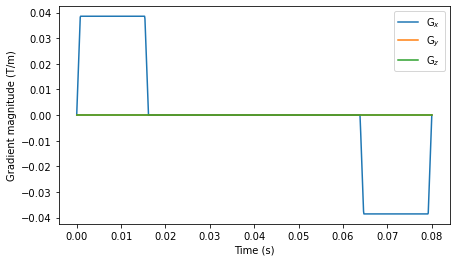

In [4]:
# Create a simple Stejskal-Tanner gradient waveform

gradient = np.zeros((1, 100, 3))
gradient[0, 1:20, 0] = 1
gradient[0, 80:99, 0] = -1


# Concatenate 100 gradient arrays with different b-values together

bs = np.linspace(1, 3e9, 100)  # Array of b-values in SI units (s/m^2)
gradient = np.concatenate([gradient for _ in bs], axis=0)


# Adjust the gradient magnitude and number of time points

n_t = int(1e3)  # Number of time points in the simulation
T = 80e-3  # Duration of gradient array in seconds
dt = T / (gradient.shape[1] - 1)  # Duration of time step
gradient, dt = gradients.interpolate_gradient(gradient, dt, n_t)
gradient = gradients.set_b(gradient, dt, bs)


# Show the gradient magnitude over time of the 50th measurement

fig, ax = plt.subplots(1, figsize=(7, 4))
for i in range(3):
    ax.plot(np.linspace(0, T, n_t), gradient[50, :, i])
ax.legend(['G$_x$', 'G$_y$', 'G$_z$'])
ax.set_xlabel('Time (s)')
ax.set_ylabel('Gradient magnitude (T/m)')
plt.show()

## Substrates

We also need to define the simulated diffusion environment, referred to as a substrate, using a substrate object. The module `disimpy.substrates` contains functions for creating substrate objects. The following examples show how to simulate diffusion without restrictions, inside a sphere, inside an infinite cylinder, inside an ellipsoid, and restricted by arbitrary geometries defined by triangular meshes.

### Free diffusion

Starting simulation
The trajectories file will be up to 0.075 GB
Number of random walkers = 1000
Number of steps = 1000
Step length = 9.84731927834662e-07 m
Step duration = 8.080808080808081e-05 s
Simulation finished.


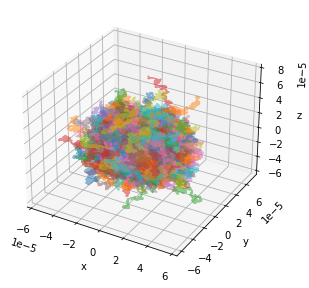

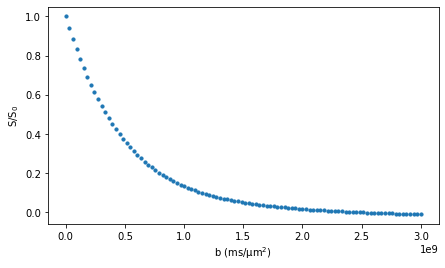

In [5]:
# Create a substrate object for free diffusion

substrate = substrates.free()


# Run simulation and show the random walker trajectories

traj_file = 'example_traj.txt'
signals = simulations.simulation(
    n_walkers, diffusivity, gradient, dt, substrate, traj=traj_file)
utils.show_traj(traj_file)


# Plot the simulated signal

fig, ax = plt.subplots(1, figsize=(7, 4))
ax.scatter(bs, signals / n_walkers, s=10)
ax.set_xlabel('b (ms/μm$^2$)')
ax.set_ylabel('S/S$_0$')
plt.show()

### Spheres

Simulating diffusion inside a sphere requires specifying the radius of the sphere:

Starting simulation
The trajectories file will be up to 0.075 GB
Number of random walkers = 1000
Number of steps = 1000
Step length = 9.84731927834662e-07 m
Step duration = 8.080808080808081e-05 s
Simulation finished.


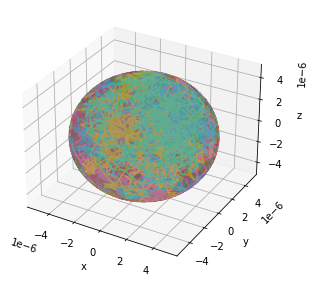

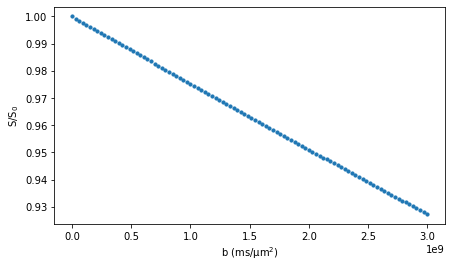

In [6]:
# Create a substrate object for diffusion inside a sphere

substrate = substrates.sphere(radius=5e-6)


# Run simulation and show the random walker trajectories

traj_file = 'example_traj.txt'
signals = simulations.simulation(
    n_walkers, diffusivity, gradient, dt, substrate, traj=traj_file)
utils.show_traj(traj_file)


# Plot the simulated signal

fig, ax = plt.subplots(1, figsize=(7, 4))
ax.scatter(bs, signals / n_walkers, s=10)
ax.set_xlabel('b (ms/μm$^2$)')
ax.set_ylabel('S/S$_0$')
plt.show()

### Infinite cylinder

Simulating diffusion inside an infinite cylinders requires specifying the radius and orientation of the cylinder:

Starting simulation
The trajectories file will be up to 0.075 GB
Number of random walkers = 1000
Number of steps = 1000
Step length = 9.84731927834662e-07 m
Step duration = 8.080808080808081e-05 s
Simulation finished.


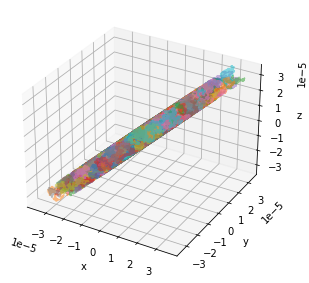

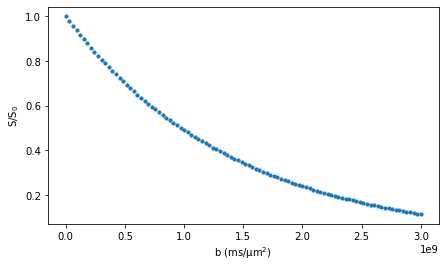

In [7]:
# Create a substrate object for diffusion inside an infinite cylinder

substrate = substrates.cylinder(
    radius=5e-6, orientation=np.array([1., 1., 1.]))


# Run simulation and show the random walker trajectories

traj_file = 'example_traj.txt'
signals = simulations.simulation(
    n_walkers, diffusivity, gradient, dt, substrate, traj=traj_file)
utils.show_traj(traj_file)


# Plot the simulated signal

fig, ax = plt.subplots(1, figsize=(7, 4))
ax.scatter(bs, signals / n_walkers, s=10)
ax.set_xlabel('b (ms/μm$^2$)')
ax.set_ylabel('S/S$_0$')
plt.show()

### Ellipsoids

Simulating diffusion inside an ellipsoid requires specifying the ellipsoid semiaxes and a rotation matrix, defining the ellipsoid orientation, according to which the axis-aligned ellipsoid is rotated before the simulation:

Starting simulation
The trajectories file will be up to 0.075 GB
Number of random walkers = 1000
Number of steps = 1000
Step length = 9.84731927834662e-07 m
Step duration = 8.080808080808081e-05 s
Simulation finished.


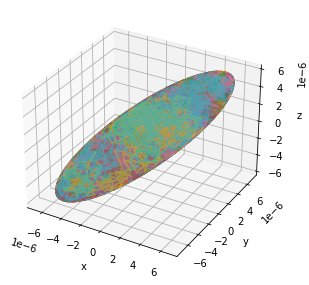

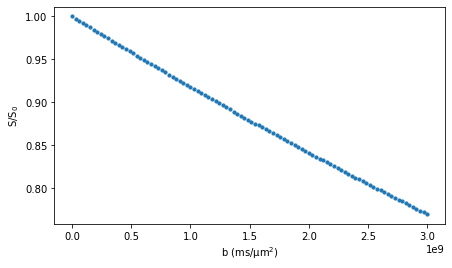

In [8]:
# Create a substrate object for diffusion inside an ellipsoid

v = np.array([1., 0, 0])
k = np.array([1., 1., 1.])
R = utils.vec2vec_rotmat(v, k)  # R for aligning v with k
substrate = substrates.ellipsoid(
    semiaxes=np.array([10e-6, 5e-6, 2.5e-6]), R=R)


# Run simulation and show the random walker trajectories

traj_file = 'example_traj.txt'
signals = simulations.simulation(
    n_walkers, diffusivity, gradient, dt, substrate, traj=traj_file)
utils.show_traj(traj_file)


# Plot the simulated signal

fig, ax = plt.subplots(1, figsize=(7, 4))
ax.scatter(bs, signals / n_walkers, s=10)
ax.set_xlabel('b (ms/μm$^2$)')
ax.set_ylabel('S/S$_0$')
plt.show()

### Triangular meshes

Diffusion inside arbitrary geometries can be simulated using triangular meshes.

Triangular meshes represented by `numpy.ndarray` instances of shape (number of triangles, 3, 3) where the second dimension indices correspond to different triangle points and the third dimension indices correspond to the Cartesian coordinates of the points of the triangle.

By default, the initial positions of the random walkers are randomly sampled from the axis-aligned bounding box of the set of triangles. If the triangles define a closed surface, the initial positions of the random walkers can be randomly sampled from the volume inside or outside the surface. Alternatively, the initial positions can be defined manually. 

If you use Disimpy with the same GPU that runs your operating system's graphical user interface, this imposes restrictions on the maximum duration that a CUDA kernel call can take. In case of complicated geometries and/or long step lenghts, it is possible that the intersection check algorithm exceeds this limit, leading to a termination of the program. However, these problems should not occur with simple geometries for which Disimpy has primarily been developed for.

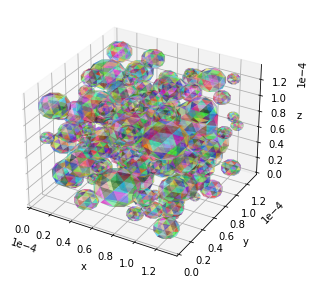

Starting simulation
The trajectories file will be up to 0.075 GB
Number of random walkers = 1000
Number of steps = 1000
Step length = 9.84731927834662e-07 m
Step duration = 8.080808080808081e-05 s
Finished calculating initial positions
Simulation finished.


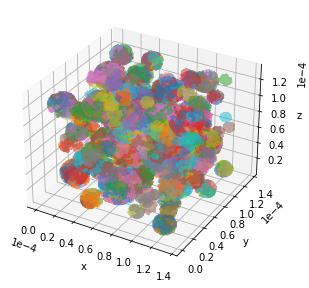

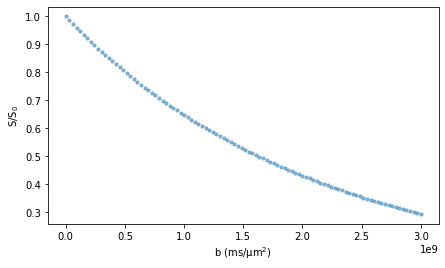

In [9]:
# Load and show a triangular mesh

mesh_path = os.path.join(
    os.path.dirname(simulations.__file__), 'tests', 'example_mesh.npy')
triangles = np.load(mesh_path)
utils.show_mesh(triangles)


# Create a substrate object for diffusion inside the surface

substrate = substrates.mesh(triangles, periodic=True, init_pos='intra')


# Run simulation and show the random walker trajectories

traj_file = 'example_traj.txt'
signals = simulations.simulation(
    n_walkers, diffusivity, gradient, dt, substrate, traj=traj_file)
utils.show_traj(traj_file)


# Plot the simulated signal

fig, ax = plt.subplots(1, figsize=(7, 4))
ax.scatter(bs, signals / n_walkers, s=10, alpha=.5)
ax.set_xlabel('b (ms/μm$^2$)')
ax.set_ylabel('S/S$_0$')
plt.show()

In [10]:
# Detailed information about the functions can be found in the docstrings

simulations.simulation?

Signature:
simulations.simulation(
    n_walkers,
    diffusivity,
    gradient,
    dt,
    substrate,
    seed=123,
    traj=None,
    final_pos=False,
    all_signals=False,
    quiet=False,
    cuda_bs=128,
    max_iter=1000,
    gamma=267513000.0,
)
Docstring:
Execute a dMRI simulation. For a detailed tutorial, please see the
documentation at https://disimpy.readthedocs.io/en/latest/tutorial.html.

Parameters
----------
n_walkers : int
    Number of random walkers.
diffusivity : float
    Diffusivity in SI units (m^2/s).
gradient : numpy.ndarray
    Array of shape (number of measurements, number of time points, 3). Array
    elements are floating-point numbers representing the gradient magnitude
    at that time point in SI units (T/m).
dt : float
    Duration of a time step in the gradient array in SI units (s).
substrate : disimpy.substrates._Substrate
    Substrate object that contains information about the simulated
    microstructure.
seed : int, optional
    Seed for pseudor

## A more interesting example

To illustrate the utility of Disimpy in more interesting scenarios than the trivial examples shown above, this example reproduces the diffraction pattern reported in Figure 2A in "Three-dimensional water diffusion in impermeable cylindrical tubes: theory versus experiments" by Avram et al. (https://doi.org/10.1002/nbm.1277). This example may take a few minutes or more to run depending on your GPU.

Starting simulation
Number of random walkers = 100000
Number of steps = 8060
Step length = 7.74692790935623e-07 m
Step duration = 5.0012410027302064e-05 s
Simulation finished.


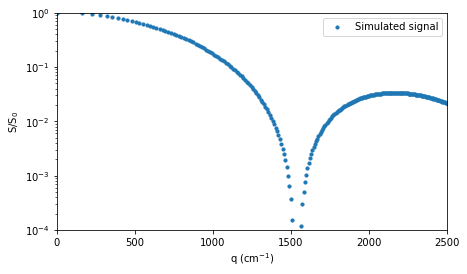

In [11]:
# Define the simulation parameters and gradient array

n_walkers = int(1e5)
diffusivity = 2e-9
bs = np.linspace(1, 1e12, 250)  # b-values in SI units
delta = 3e-3  # Gradient pulse duration in seconds
DELTA = 400e-3  # Diffusion time in seconds
T = DELTA + delta  # Duration of gradient array
gradient = np.zeros((1, 4030, 3))
gradient[0, 1:30, 0] = 1
gradient[0, 4000:4029, 0] = -1
gradient = np.concatenate([gradient for _ in bs], axis=0)
dt = T / (gradient.shape[1] - 1)
gradient, dt = gradients.interpolate_gradient(
    gradient, dt, int(gradient.shape[1] * 2))
gradient = gradients.set_b(gradient, dt, bs)
delta = np.sum(gradient[-1, :, :] > 0) * dt
DELTA = np.min(np.where(gradient[-1, :, 0] < 0)) * dt
q = gradients.calc_q(gradient, dt)  # Calculate q-vectors
qs = np.max(np.linalg.norm(q, axis=2), axis=1)


# Define the substrate

substrate =substrates.cylinder(
    radius=4.5e-6, orientation=np.array([0, 0, 1.]))


# Run simulation

signals = simulations.simulation(
    n_walkers, diffusivity, gradient, dt, substrate)


# Plot signal decay showing the diffraction pattern at high values of q

fig, ax = plt.subplots(1, figsize=(7, 4))
ax.scatter(qs * 1e-2 / (2 * np.pi), signals/n_walkers, s=10)
ax.legend(['Simulated signal'])
ax.set_xlabel('q (cm$^{-1}$)')
ax.set_ylabel('S/S$_0$')
ax.set_yscale('log')
ax.set_ylim([1e-4, 1])
ax.set_xlim([0, 2500])
plt.show()

## Advanced information

For details, please see the [source code](https://github.com/kerkelae/disimpy).